## Load EEG Data
Extracted trial EEG Data from each subject

In [1]:
import numpy as np
from scipy.signal import iirnotch, butter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Subject-specific filenames
subject_files = {
    "Subject_P": "eeg_experiment_20250317_145000_P.npy",
    "Subject_A": "eeg_experiment_20250319_114841_A.npy",
    "Subject_C": "eeg_experiment_20250319_121857_C.npy"
}

# EEG channels of interest
channels = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "Cz", "Pz"]

In [3]:
# List to store raw EEG trials
raw_trials = []

for subject, file in subject_files.items():
    data = np.load(file, allow_pickle=True).item()

    for condition in ["HighAttention", "LowAttention", "Fatigue"]:
        trial = data.get(condition, {}).get("trials")
        
        if trial is not None:
            # Convert from dictionary to NumPy array (stack channels)
            eeg_matrix = np.vstack([trial[ch] for ch in channels])
            
            raw_trials.append({
                "subject": subject,
                "condition": condition,
                "eeg": eeg_matrix
            })

### Apply Filter

Notch Filter (60Hz) to remove powerline noise

In [4]:
# Sampling rate
fs = 250  
notch_freq = 60.0
quality_factor = 30.0
b_notch, a_notch = iirnotch(notch_freq, quality_factor, fs)

# High-pass filter at 0.5 Hz to remove DC drift
lowcut = 0.5
b_high, a_high = butter(5, lowcut / (fs/2), btype='high')

# Apply Notch filter and High-pass filter
filtered_trials = []

for trial in raw_trials:
    eeg_raw = trial["eeg"]

    # Apply Notch Filter (60Hz)
    eeg_notched = filtfilt(b_notch, a_notch, eeg_raw, axis=1)

    # Apply High-pass filter (0.5 Hz) to remove slow drift
    eeg_filtered = filtfilt(b_high, a_high, eeg_notched, axis=1)

    # Store filtered data
    filtered_trials.append({
        "subject": trial["subject"],
        "condition": trial["condition"],
        "eeg": eeg_filtered
    })

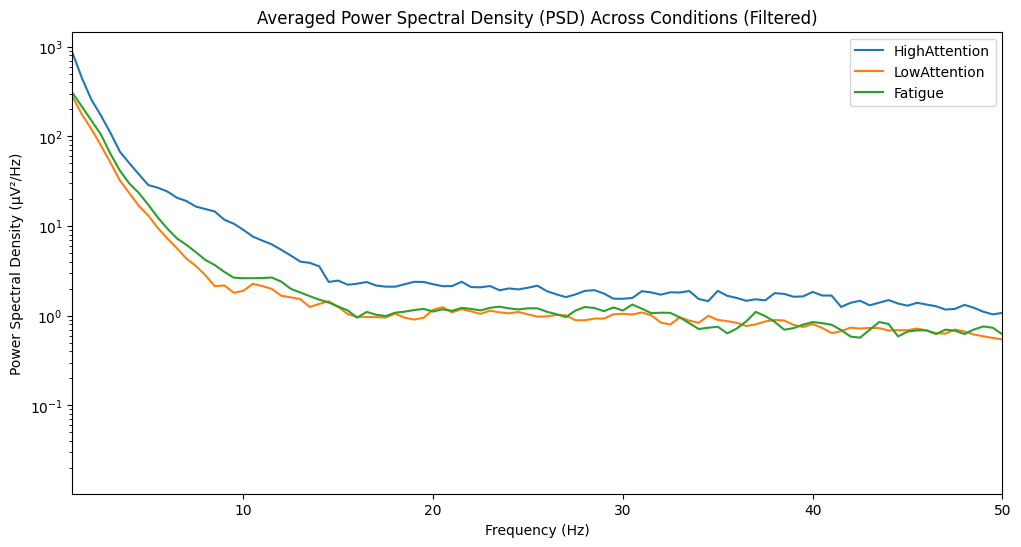

In [5]:
# Compute PSD for each condition
nperseg = fs * 2  # 2-second windows for Welch's method
psd_data_filtered = {}

for condition in ["HighAttention", "LowAttention", "Fatigue"]:
    all_psds = []

    for trial in filtered_trials:
        if trial["condition"] == condition:
            eeg_trial = trial["eeg"]  # Shape: (channels x time)

            # Compute PSD for each channel and store mean across trials
            psds = np.array([welch(eeg_trial[ch, :], fs=fs, nperseg=nperseg)[1] for ch in range(eeg_trial.shape[0])])
            all_psds.append(np.mean(psds, axis=0))  # Average across channels

    # Compute mean PSD across trials for this condition
    psd_data_filtered[condition] = np.mean(all_psds, axis=0)

# Get frequency axis (from Welch's method)
freqs, _ = welch(eeg_trial[0, :], fs=fs, nperseg=nperseg)

# Plot PSD for each condition
plt.figure(figsize=(12, 6))

for condition, psd in psd_data_filtered.items():
    plt.semilogy(freqs, psd, label=condition)  # Log scale to highlight differences

plt.xlim(1, 50)  # Focus on 1-50 Hz range
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (μV²/Hz)")
plt.title("Averaged Power Spectral Density (PSD) Across Conditions (Filtered)")
plt.legend()
plt.show()

In [6]:
# Define EEG bands
eeg_bands = {
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (12-30 Hz)": (12, 30),
    "Gamma (30-50 Hz)": (30, 50),
}

# Compute band power
band_power = {band: {cond: [] for cond in psd_data_filtered.keys()} for band in eeg_bands.keys()}
for band, (low, high) in eeg_bands.items():
    band_indices = np.where((freqs >= low) & (freqs <= high))[0]
    for condition, psd in psd_data_filtered.items():
        band_avg_power = np.mean(psd[band_indices])
        band_power[band][condition] = band_avg_power

# Convert to DataFrame and display
df_band_power = pd.DataFrame(band_power)

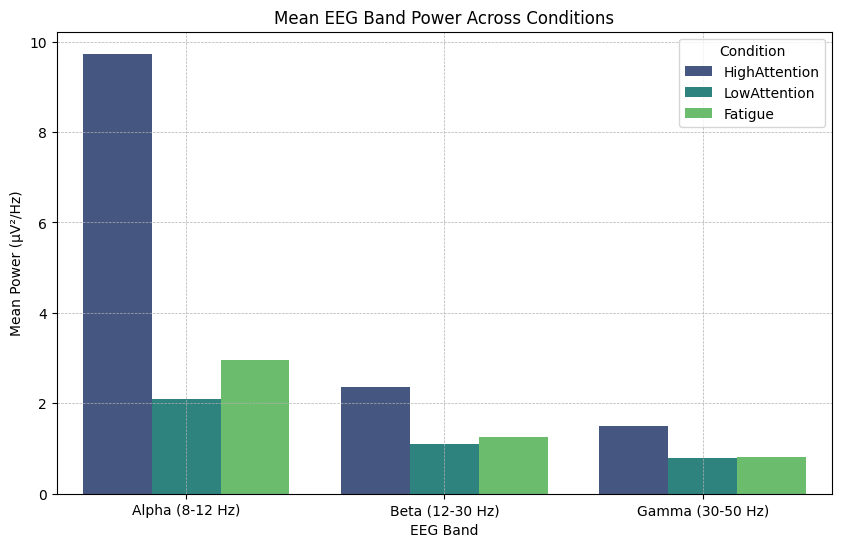

In [7]:
# Convert DataFrame to long format for Seaborn
df_long = df_band_power.T.reset_index().melt(id_vars="index", var_name="Condition", value_name="Power")
df_long.rename(columns={"index": "EEG Band"}, inplace=True)

# Create Seaborn barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="EEG Band", y="Power", hue="Condition", palette="viridis")

plt.xlabel("EEG Band")
plt.ylabel("Mean Power (μV²/Hz)")
plt.title("Mean EEG Band Power Across Conditions")
plt.legend(title="Condition")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation=0)
plt.show()